# Adversarial Training using Fast Better than Free Implementation
### Ref (https://arxiv.org/abs/2001.03994https://arxiv.org/abs/2001.03994)

In [1]:
# Environment installation (e.g for colab usage)
#!pip install adversarial-robustness-toolbox
#!pip install tf-nightly==2.3.0-dev20200521

In [ ]:
# Main imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import fbfadvtrain
import activationsf

# Modelling imports
from tensorflow.keras import layers 
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses, optimizers, metrics
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential

In [4]:
# Load CIFAR10
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

In [5]:
from tensorflow.keras.activations import swishfrom tensorflow.keras.activations import swish

tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
kaf_swish_cnn = Sequential([
  
  # VGG inspired model:
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_1', ridge=swish),
  layers.Conv2D(32, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_2', ridge=swish),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),

  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_3', ridge=swish),
  layers.Conv2D(64, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_4', ridge=swish),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_5', ridge=swish),
  layers.Conv2D(128, 3, padding='same', activation=None, kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  activationsf.Kaf(conv=True, D=20, name='kaf_6', ridge=swish),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3),

  layers.Flatten(),
  layers.Dense(64, activation=None, kernel_regularizer=regularizers.l2(0.0012)),
  activationsf.Kaf(D=20, name='kaf_7', ridge=swish),
  layers.Dropout(0.4),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

In [ ]:
# Using swish w/o KAFs
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
swish_cnn = Sequential([
  
  # Using KAFs instead
  layers.Conv2D(32, 3, padding='same', activation='swish', kernel_initializer='he_uniform',  input_shape = (32, 32, 3)),
  layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_1', ridge=swish),
  layers.Conv2D(32, 3, padding='same', activation='swish', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_2', ridge=swish),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.2),

  layers.Conv2D(64, 3, padding='same', activation='swish', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_3', ridge=swish),
  layers.Conv2D(64, 3, padding='same', activation='swish', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_4', ridge=swish),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),

  layers.Conv2D(128, 3, padding='same', activation='swish', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_5', ridge=swish),
  layers.Conv2D(128, 3, padding='same', activation='swish', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  #activationsf.Kaf(conv=True, D=16, name='kaf_6', ridge=swish),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3),

  layers.Flatten(),
  layers.Dense(64, activation='swish', kernel_regularizer=regularizers.l2(0.0012)),
  #activationsf.Kaf(D=16, name='kaf_7', ridge=swish),
  layers.Dropout(0.4),
  layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0012), dtype=tf.float32)
])

In [ ]:
swish_cnn.summary()

In [ ]:
kaf_swish_cnn.summary()

In [ ]:
# Create an adversarially trainable models using fbfadvtrain utilities 
rob_kaf_swish_cnn = fbfadvtrain.FastBetterFreeTrainedModel(inputs=kaf_swish_cnn.inputs, outputs=kaf_swish_cnn.outputs)
rob_swish_cnn = fbfadvtrain.FastBetterFreeTrainedModel(inputs=swish_cnn.inputs, outputs=swish_cnn.outputs)

In [ ]:
# Compile them
rob_swish_cnn.compile(
              optimizer = tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )
rob_kaf_swish_cnn.compile(
              optimizer = tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )

In [ ]:
# If not already present
#!git clone https://github.com/WittmannF/LRFinder.git!git clone https://github.com/WittmannF/LRFinder.git

# Find the min max lr meaningful bounds to cycle through
# Ref: https://www.machinecurve.com/index.php/2020/02/25/training-your-neural-network-with-cyclical-learning-rates/
# Note need to make lRFinder/keras_callback.py tf compatible
from LRFinder.keras_callback import LRFinder
lr_finder = LRFinder(min_lr=1e-4, max_lr=1) # implemented as a callback

In [ ]:
# Perform lr range test on 10 epochs

# Kaf case
rob_kaf_swish_cnn.fit(x_train, y_train, epochs = 6, batch_size=128, callbacks=[lr_finder, activationsf.plot_kafs_epoch_wise(7)])

In [ ]:
# W/o KAFs model
rob_swish_cnn.fit(x_train, y_train, epochs = 6, batch_size=128, callbacks=[lr_finder, activationsf.plot_kafs_epoch_wise(7)])

In [ ]:
# Set up cyclic learning (linear) given the above results 
# ref: same as above
!git clone https://github.com/bckenstler/CLR.git
from CLR.clr_callback import CyclicLR

# Set CLR options
step_size = int(3 * (50000/128))
base_lr = 1e-3
max_lr = 3e-1
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=step_size, mode=mode)

In [12]:
# Set Early Stopping
# To avoid Catastrophical Overfitting? (ref paper)
es = callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-3,
        patience=7,
        mode='max', 
        restore_best_weights=True,
        verbose=1)

In [ ]:
# Plot diagnostic learning curves
def summarize_diagnostics(history, fine_tuning=False):
	
	if fine_tuning :
		color_train = 'green'
		color_validation = 'red'
	else :
		color_train = 'blue'
		color_validation = 'orange'

	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color=color_train, label='train')
	plt.plot(history.history['val_loss'], color=color_validation, label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color=color_train, label='train')
	plt.plot(history.history['val_accuracy'], color=color_validation, label='test')
	plt.show()
	plt.close()

In [ ]:
# Actual Training
history_swish = rob_swish_cnn.fit(x_train, y_train, epochs = 100, validation_data=(x_test[:2000], y_test[:2000]),batch_size=128, callbacks=[es, clr])

In [ ]:
history_kaf_swish = rob_kaf_swish_cnn.fit(x_train, y_train, epochs = 100, validation_data=(x_test[:2000], y_test[:2000]),batch_size=128, callbacks=[es, clr, activationsf.plot_kafs_epoch_wise(7)])

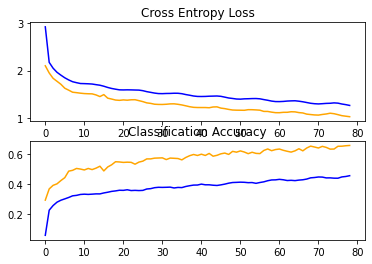

In [13]:
summarize_diagnostics(history_swish)

In [ ]:
summarize_diagnostics(history_kaf_swish)

In [ ]:
# Evaluation
rob_swish_cnn.evaluate(x_test, y_test, batch_size=128)

In [ ]:
rob_kaf_swish_cnn.evaluate(x_test, y_test, batch_size=128)

In [16]:
# Save models 
rob_swish_cnn.save('light_custom_models/swish_cnn_robust_fbf') 
rob_kaf_swish_cnn.save('light_custom_models/kaf_swish_cnn_robust_fbf') 

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
INFO:tensorflow:Assets written to: light_custom_models/elu_cnn_robust_fbf/assets
